In [268]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
import astropy.io.ascii as aa
import gzip
from matplotlib.colors import LogNorm
import pickle
import plotutils.autocorr as ac
import plotutils.plotutils as pu
import pystan
import scipy.integrate as sig
import scipy.interpolate as si
import scipy.stats as ss
import seaborn

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
seaborn.set_style('ticks')

In [96]:
def myimshow(x, y, z, *args, **kwargs):
    imshow(z.T, origin='lower', extent=(x[0], x[-1], y[0], y[-1]), *args, **kwargs)

In [101]:
def interp_extend(x, y, xlow=0, xhigh=100, *args, **kwargs):
    xs = concatenate(([xlow], x, [xhigh]))
    ys = concatenate(([y[0]], y, [y[-1]]))
    
    return si.interp1d(xs, ys, *args, **kwargs)

In [3]:
kois = aa.read('/Users/farr/Documents/Research/KepHackWeek/data/dr24_koi.csv')
kois

kepid,kepoi_name,kepler_name,ra,ra_err,ra_str,dec,dec_err,dec_str,koi_gmag,koi_gmag_err,koi_rmag,koi_rmag_err,koi_imag,koi_imag_err,koi_zmag,koi_zmag_err,koi_jmag,koi_jmag_err,koi_hmag,koi_hmag_err,koi_kmag,koi_kmag_err,koi_kepmag,koi_kepmag_err,koi_delivname,koi_vet_stat,koi_quarters,koi_disposition,koi_pdisposition,koi_count,koi_num_transits,koi_max_sngle_ev,koi_max_mult_ev,koi_bin_oedp_sig,koi_limbdark_mod,koi_ldm_coeff4,koi_ldm_coeff3,koi_ldm_coeff2,koi_ldm_coeff1,koi_trans_mod,koi_model_snr,koi_model_dof,koi_model_chisq,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_eccen,koi_eccen_err1,koi_eccen_err2,koi_longp,koi_longp_err1,koi_longp_err2,koi_prad,koi_prad_err1,koi_prad_err2,koi_sma,koi_sma_err1,koi_sma_err2,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,koi_duration_err1,koi_duration_err2,koi_ingress,koi_ingress_err1,koi_ingress_err2,koi_depth,koi_depth_err1,koi_depth_err2,koi_period,koi_period_err1,koi_period_err2,koi_ror,koi_ror_err1,koi_ror_err2,koi_dor,koi_dor_err1,koi_dor_err2,koi_incl,koi_incl_err1,koi_incl_err2,koi_teq,koi_teq_err1,koi_teq_err2,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_smet,koi_smet_err1,koi_smet_err2,koi_srad,koi_srad_err1,koi_srad_err2,koi_smass,koi_smass_err1,koi_smass_err2,koi_sage,koi_sage_err1,koi_sage_err2,koi_sparprov,koi_fwm_stat_sig,koi_fwm_sra,koi_fwm_sra_err,koi_fwm_sdec,koi_fwm_sdec_err,koi_fwm_srao,koi_fwm_srao_err,koi_fwm_sdeco,koi_fwm_sdeco_err,koi_fwm_prao,koi_fwm_prao_err,koi_fwm_pdeco,koi_fwm_pdeco_err,koi_dicco_mra,koi_dicco_mra_err,koi_dicco_mdec,koi_dicco_mdec_err,koi_dicco_msky,koi_dicco_msky_err,koi_dicco_fra,koi_dicco_fra_err,koi_dicco_fdec,koi_dicco_fdec_err,koi_dicco_fsky,koi_dicco_fsky_err,koi_dikco_mra,koi_dikco_mra_err,koi_dikco_mdec,koi_dikco_mdec_err,koi_dikco_msky,koi_dikco_msky_err,koi_dikco_fra,koi_dikco_fra_err,koi_dikco_fdec,koi_dikco_fdec_err,koi_dikco_fsky,koi_dikco_fsky_err,koi_comment,koi_vet_date,koi_tce_plnt_num,koi_tce_delivname,koi_datalink_dvs,koi_disp_prov,koi_parm_prov,koi_time0,koi_time0_err1,koi_time0_err2,koi_datalink_dvr,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_insol,koi_insol_err1,koi_insol_err2,koi_srho,koi_srho_err1,koi_srho_err2,koi_fittype
int64,str9,str14,float64,float64,str12,float64,float64,str12,float64,int64,float64,int64,float64,int64,float64,int64,float64,float64,float64,float64,float64,float64,float64,int64,str15,str4,float64,str14,str14,int64,int64,float64,float64,int64,str33,float64,float64,float64,float64,str34,float64,int64,int64,float64,float64,float64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,int64,int64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,int64,int64,int64,str14,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,str225,str10,int64,str15,str64,str15,str15,float64,float64,float64,str60,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,str4
7697568,K01829.01,--,296.52243,0.0,19h46m05.38s,43.363369,0.0,+43d21m48.1s,16.591,--,15.841,--,15.62,--,15.448,--,14.437,0.029,14.033,0.031,13.865,0.049,15.911,--,q1_q17_dr24_koi,Done,1.11111111111e+30,CANDIDATE,CANDIDATE,2,57,12.036085,50.30746,--,Claret (2011 A&A 529 75) ATLAS LS,0.0,0.0,0.2223,0.4689,Mandel and Agol (2002 ApJ 580 171),60.5,--,--,138.63416,0.00119,-0.00119,0,--,--,--,--,--,23.37,8.48,-1.93,0.1499,--,--,1.1845,0.5157,-0.1152,2.6837,0.0633,-0.0633,--,--,--,3390.3,71.2,-71.2,22.84151055,3.352e-05,-3.352e-05,0.260388,0.504439,-0.100065,28.03,6.5,-6.5,87.66,--,--,556.

In [192]:
pbins = loadtxt('pbins.dat.gz')
rbins = loadtxt('rbins.dat.gz')

In [171]:
geff = loadtxt('g-integrated-eff.dat.gz')
gids = geff[:,0]
geff = geff[:,1:].reshape((geff.shape[0], pbins.shape[0]-1, rbins.shape[0]-1))
gids = set([int(round(gid)) for gid in gids])

In [6]:
candidates = kois[kois['koi_pdisposition']=='CANDIDATE']
candidates = candidates[candidates['koi_max_mult_ev'] > 15]
candidates = candidates[(candidates['koi_period'] >= pbins[0]) & (candidates['koi_period'] < pbins[-1])]

In [7]:
pobs = []
robs = []
drobs = []
for c in candidates:
    if c['kepid'] in gids:
        pobs.append(c['koi_period'])
        robs.append(c['koi_prad'])
        drobs.append(c['koi_prad_err1'] - c['koi_prad_err2'])
pobs = array(pobs)
robs = array(robs)
drobs = array(drobs)
sel = (~np.isnan(pobs)) & (~np.isnan(robs)) & (~np.isnan(drobs))
pobs = pobs[sel]
robs = robs[sel]
drobs = drobs[sel]
sel = (pobs > 0) & (robs > 0) & (drobs > 0)
pobs = pobs[sel]
robs = robs[sel]
drobs = drobs[sel]

/Users/farr/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/numpy/ma/core.py:3900: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


In [8]:
rmin = 0.0
rmax = 100.0

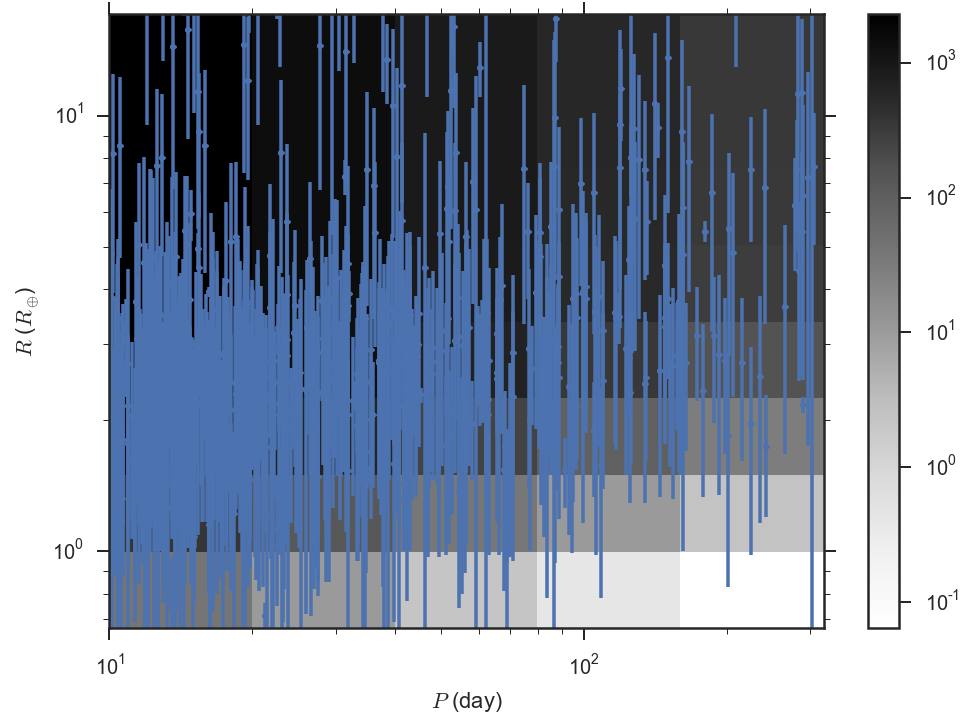

In [9]:
PS, RS = meshgrid(pbins, rbins, indexing='ij')
pcolormesh(PS, RS, sum(geff, axis=0), norm=LogNorm())
errorbar(pobs, robs, drobs, fmt='.')
colorbar()
xscale('log')
yscale('log')
axis(xmin=pbins[0], xmax=pbins[-1], ymin=rbins[0], ymax=rbins[-1])
xlabel(r'$P$ (day)')
ylabel(r'$R$ ($R_\oplus$)')

In [10]:
data = {'nobs': robs.shape[0],
        'nps': pbins.shape[0]-1,
        'nrs': rbins.shape[0]-1,
        'pbins': pbins,
        'rbins': rbins,
        'pobs': pobs,
        'robs': robs,
        'drobs': drobs,
        'alphas': sum(geff, axis=0),
        'rmin': 0.01,
        'rmax': 100.0}

In [13]:
fit = pystan.stan(file='binned.stan', data=data)

In [14]:
fit

Inference for Stan model: anon_model_71208a8d43fc2c45c15569aa0f11119b.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                  mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
rawrate[0,0]     -0.36    0.02   0.74  -1.84  -0.84  -0.35   0.16   1.04 1092.0    1.0
rawrate[1,0]       0.3    0.03   0.96  -1.61  -0.35   0.31   0.96   2.19 1334.0    1.0
rawrate[2,0]      0.08    0.03    1.0  -1.92  -0.61    0.1   0.77   2.01 1334.0    1.0
rawrate[3,0]     -0.06    0.03   0.95  -1.98   -0.7  -0.05   0.59   1.84 1334.0    1.0
rawrate[4,0]     -0.01    0.03   0.98  -1.98  -0.65-7.2e-3   0.63   1.91 1334.0    1.0
rawrate[0,1]      0.37    0.02   0.79  -1.12  -0.17   0.33   0.89   1.97 1189.0    1.0
rawrate[1,1]     -0.06    0.02   0.88   -1.8  -0.65  -0.06   0.53   1.66 1334.0    1.0
rawrate[2,1]      0.12    0.03   0.96  -1.83  -0.53   0.11   0.78   1.97 1334.0    1.0
rawrate[3,1]      -0.1    0.

In [15]:
samples = fit.extract(permuted=True)
with gzip.open('stan-samples.pkl.gz', 'w') as out:
    pickle.dump(samples, out)

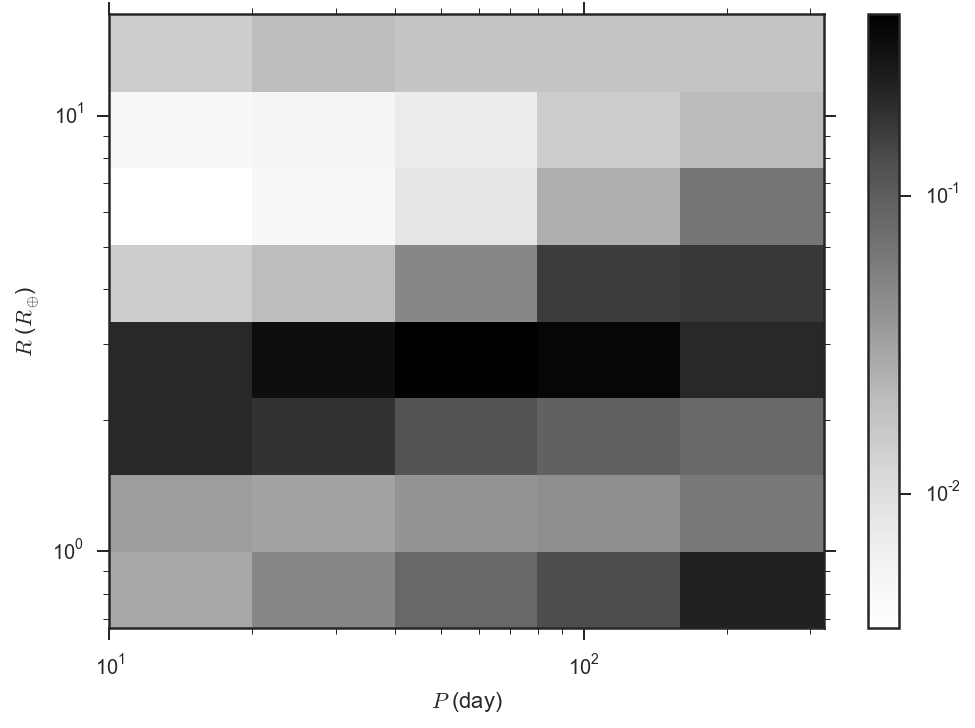

In [16]:
pcolormesh(PS, RS, mean(samples['dndlnpdlnr'], axis=0), norm=LogNorm())
colorbar()
xscale('log')
yscale('log')
axis(xmin=pbins[0], xmax=pbins[-1], ymin=rbins[0], ymax=rbins[-1])
xlabel(r'$P$ (day)')
ylabel(r'$R$ ($R_\oplus$)')

## Smaller Bins, More Candidates

In [16]:
sel = (kois['koi_max_mult_ev'] >= 15) & (kois['koi_pdisposition'] == 'CANDIDATE')
sel = sel & array([k['kepid'] in gids for k in kois])
sel = sel & (kois['koi_prad'] > 0) & (kois['koi_period'] > 0) & (kois['koi_prad_err1'] > 0) & (kois['koi_prad_err2'] < 0)
candidates = kois[sel]
print len(candidates)

1172


In [204]:
pmin = np.min(candidates['koi_period'])
pmax = np.max(candidates['koi_period'])
pbins = exp(arange(log(pmin)-0.5, log(pmax)+0.5, 0.5))
print pbins

[  3.17928872e-01   5.24176094e-01   8.64220276e-01   1.42485835e+00
   2.34919427e+00   3.87316656e+00   6.38577210e+00   1.05283583e+01
   1.73583283e+01   2.86190450e+01   4.71848283e+01   7.77946300e+01
   1.28261661e+02   2.11467729e+02   3.48651343e+02   5.74828886e+02]


In [205]:
rbins = exp(arange(log(0.5)-0.5, log(20.0)+0.5, 0.5))
print rbins

[  0.30326533   0.5          0.82436064   1.35914091   2.24084454
   3.69452805   6.09124698  10.04276846  16.55772598  27.29907502]


In [186]:
PS, RS = meshgrid(pbins, rbins, indexing='ij')

In [27]:
stellar = aa.read('/Users/farr/Documents/Research/KepHackWeek/data/dr24_stellar.csv')

In [38]:
stellar

kepid,tm_designation,teff,teff_err1,teff_err2,logg,logg_err1,logg_err2,feh,feh_err1,feh_err2,mass,mass_err1,mass_err2,radius,radius_err1,radius_err2,dens,dens_err1,dens_err2,prov_sec,kepmag,nconfp,nkoi,ntce,datalink_dvr,st_delivname,st_vet_date_str,ra,ra_str,dec,dec_str,st_quarters,teff_prov,logg_prov,feh_prov,jmag,jmag_err,hmag,hmag_err,kmag,kmag_err,dutycycle,dataspan,mesthres01p5,mesthres02p0,mesthres02p5,mesthres03p0,mesthres03p5,mesthres04p5,mesthres05p0,mesthres06p0,mesthres07p5,mesthres09p0,mesthres10p5,mesthres12p0,mesthres12p5,mesthres15p0,rrmscdpp01p5,rrmscdpp02p0,rrmscdpp02p5,rrmscdpp03p0,rrmscdpp03p5,rrmscdpp04p5,rrmscdpp05p0,rrmscdpp06p0,rrmscdpp07p5,rrmscdpp09p0,rrmscdpp10p5,rrmscdpp12p0,rrmscdpp12p5,rrmscdpp15p0
int64,str25,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str6,float64,int64,int64,int64,str60,str19,str10,float64,str12,float64,str12,int64,str5,str5,str5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
10022892,2MASS J19444068+4656575,4862,169,-136,4.559,0.03,-0.067,0.32,0.12,-0.25,0.83,0.07,-0.07,0.794,0.081,-0.049,2.347,0.3124,-0.523,DSEP,15.799,0,0,0,--,q1_q17_dr24_stellar,2015-01-15,296.169525,19h44m40.69s,46.949329,+46d56m57.6s,11111101110111011,PHO1,KIC0,KIC0,14.19,0.028,13.633,0.03,13.544,0.042,0.6988,1459.789,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,380.093,339.87,321.107,299.647,286.905,264.919,254.865,241.038,225.333,214.82,208.316,202.644,201.268,196.301
10022896,2MASS J19444107+4659087,6065,142,-231,4.452,0.045,-0.22,0.21,0.15,-0.35,1.16,0.17,-0.17,1.061,0.324,-0.106,1.37,0.3151,-0.7296,DSEP,15.767,0,0,0,--,q1_q17_dr24_stellar,2015-01-15,296.171143,19h44m41.07s,46.98576,+46d59m08.7s,11111101110111011,PHO1,KIC0,KIC0,14.621,0.028,14.251,0.04,14.142,0.059,0.6989,1459.789,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,358.858,316.941,296.307,273.004,258.306,229.677,217.581,200.543,182.927,169.778,159.763,151.308,148.843,137.387
10022908,2MASS J19444255+4659564,4848,151,-126,4.598,0.016,-0.072,0.34,0.12,-0.26,0.85,0.05,-0.08,0.769,0.064,-0.039,2.644,0.2472,-0.5611,DSEP,14.94,0,1,1,010/010022/010022908/dv/kplr010022908-20141002224145_dvr.pdf,q1_q17_dr24_stellar,2015-01-15,296.177277,19h44m42.55s,46.99902,+46d59m56.5s,11111101110111011,PHO1,KIC0,KIC0,13.375,0.022,12.835,0.022,12.701,0.023,0.6986,1459.789,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,219.254,196.482,186.19,172.92,164.882,149.918,143.66,134.247,124.355,116.9,112.088,108.182,107.503,102.807
10022925,2MASS J19444430+4658488,6343,140,-233,4.411,0.054,-0.322,0.07,0.17,-0.37,1.21,0.24,-0.2,1.137,0.621,-0.126,1.164,0.3162,-0.7985,DSEP,13.529,0,0,0,--,q1_q17_dr24_stellar,2015-01-15,296.184601,19h44m44.30s,46.98024,+46d58m48.9s,11111101110111011,PHO1,KIC0,KIC0,12.529,0.021,12.21,0.019,12.156,0.021,0.6987,1459.789,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,91.193,80.581,75.315,69.424,65.678,58.815,55.94,51.504,46.933,43.248,40.441,38.322,37.734,33.829
10022963,2MASS J19444620+4654451,5926,163,-182,4.519,0.033,-0.244,-0.12,0.22,-0.28,1.0,0.1,-0.12,0.913,0.299,-0.074,1.858,0.3207,-1.056,DSEP,15.216,0,0,0,--,q1_q17_dr24_stellar,2015-01-15,296.192505,19h44m46.20s,46.91254,+46d54m45.1s,40140900696584,PHO1,KIC0,KIC0,14.049,0.022,13.735,0.025,13.622,0.042,0.5025,1387.849,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,246.163,218.16,203.832,186.738,176.192,157.518,149.833,138.901,126.629,116.842,108.69,102.806,101.392,93.646
10023002,2MASS J19444948+4657598,5823,142,-196,4.473,0.043,-0.292,0.36,0.08,-0.32,1.13,0.19,-0.16,1.02,0.42,-0.091,1.499,0.314,-0.952,DSEP,11.82,0,0,0,--,q1_q17_dr24_stellar,2015-01-15,296.206177,19h44m49.48s,46.966629,+46d57m59.9s,1111110111011101

In [200]:
def pdetect(ps, rs, star):
    tdurs = array([1.5, 2.0, 2.5, 3.0, 3.5, 4.5, 5.0, 6.0, 7.5, 9.0, 10.5, 12.0, 12.5, 15.0])
    labels = ['rrmscdpp{:02d}p{:d}'.format(int(round(modf(td)[1])), int(round(modf(td)[0]*10.0))) for td in tdurs]
    cdpps = array([star[l] for l in labels])
    cdpp = si.interp1d(tdurs, cdpps, fill_value=np.inf, bounds_error=False)
    
    labels = ['mesthres{:02d}p{:d}'.format(int(round(modf(td)[1])), int(round(modf(td)[0]*10.0))) for td in tdurs]
    mesths = array([star[l] for l in labels])
    mesth = si.interp1d(tdurs, mesths, fill_value=np.inf, bounds_error=False)
    
    smas = (star['mass']*square(ps/365.25))**(1.0/3.0) # AU
    vels = 2.0*pi*smas / ps # AU / day
    vels *= 8.96 # RSun / hr
    trans_times = 2*star['radius'] / vels # hr
        
    depths = square(rs * 6371.0 / 695500.0 / star['radius'])
    
    ntrs = star['dataspan']*star['dutycycle']/ps
    
    # 0.84 from Burke+ (2015)
    snrs = 0.84*1e6*depths / cdpp(trans_times) * sqrt(ntrs)
    
    x = snrs - 4.1 - (mesth(trans_times) - 7.1)
    
    # Estimate the window function (taken from Foreman-Mackey's blog)
    M = star['dataspan'] / ps
    f = star['dutycycle']
    omf = 1 - f
    pw = 1 - omf**M - M*f*omf**(M-1) - 0.5*M*(M-1)*f*f*omf**(M-2)
    mask = (pw >= 0) & (M >= 2)
        
    return ss.gamma.cdf(x, 4.65, scale=0.98)*pw*mask

In [201]:
def ptransit(ps, star):
    smas = (star['mass']*square(ps/365.25))**(1.0/3.0) # AU
    smas *= 215.1 # solar radii
    
    ptr = (2*star['radius']) / (pi * smas)
    ptr[ptr > 1.0] = 1.0
    
    return ptr

In [202]:
pinterps = exp(linspace(log(pbins[0]), log(pbins[-1]), 100))
rinterps = exp(linspace(log(rbins[0]), log(rbins[-1]), 100))
PS, RS = meshgrid(pinterps, rinterps, indexing='ij')
my_geff = 0
gids = set([])
for s in stellar:
    if s['logg'] >= 4.0 and s['dutycycle'] > 0.33 and s['kepmag'] > 5 and s['dataspan'] > 2*365.25 and s['teff'] >= 5300 and s['teff'] < 6000 and np.all(np.isfinite(s['mass'])):
        my_geff += pdetect(PS, RS, s)*ptransit(PS, s)
        gids = gids.union([s['kepid']])

<matplotlib.colorbar.Colorbar instance at 0x1262d3950>

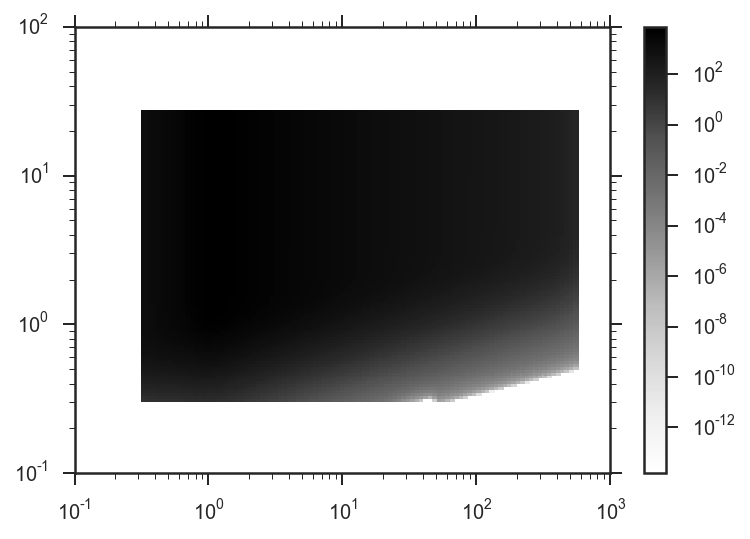

In [203]:
pcolormesh(PS, RS, my_geff, norm=LogNorm())
xscale('log')
yscale('log')
colorbar()

In [217]:
PS, RS = meshgrid(pinterps, rinterps, indexing='ij')
alphas = zeros((pbins.shape[0]-1, rbins.shape[0]-1))
for i in range(pbins.shape[0]-1):
    for j in range(rbins.shape[0]-1):
        pmin = pbins[i]
        pmax = pbins[i+1]
        rmin = rbins[j]
        rmax = rbins[j+1]
        
        sel = (PS >= pmin) & (PS < pmax) & (RS >= rmin) & (RS < rmax)
        alphas[i,j] = np.mean(my_geff[sel])

(0.31792887209941134,
 574.8288855359126,
 0.30326532985631671,
 27.299075016572118)

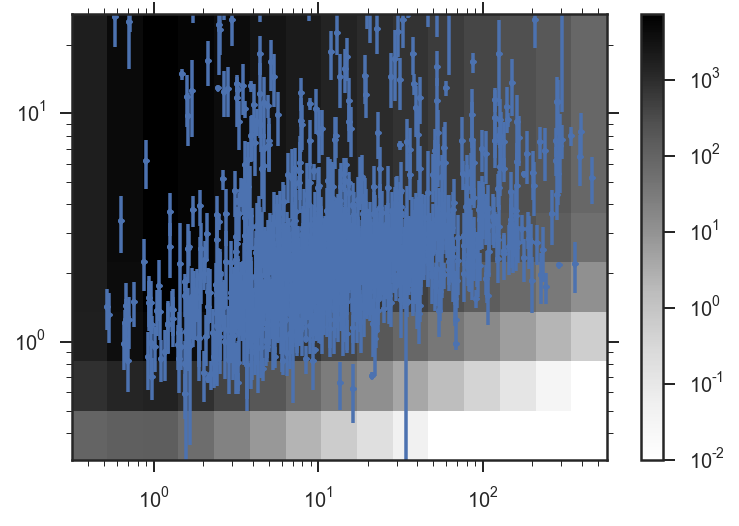

In [222]:
PS, RS = meshgrid(pbins, rbins, indexing='ij')
alphas[alphas < 0.01] = 0.01
pcolormesh(PS, RS, alphas, norm=LogNorm())
colorbar()
xscale('log')
yscale('log')
errorbar(candidates['koi_period'], candidates['koi_prad'], 0.5*(candidates['koi_prad_err1']-candidates['koi_prad_err2']), fmt='.')
axis(xmin=np.min(PS), xmax=np.max(PS), ymin=np.min(RS), ymax=np.max(RS))

In [225]:
data = {'nobs': len(candidates),
        'nps': len(pbins)-1,
        'nrs': len(rbins)-1,
        'pbins': pbins,
        'rbins': rbins,
        'pobs': candidates['koi_period'],
        'robs': candidates['koi_prad'],
        'drobs': 0.5*(candidates['koi_prad_err1'] - candidates['koi_prad_err2']),
        'alphas': alphas,
        'rmin': 0.1,
        'rmax': 100}

In [258]:
fit = pystan.stan(file='binned.stan', data=data)

In [259]:
samples = fit.extract(permuted=True)

In [260]:
with gzip.open('stan-samples.pkl.gz', 'w') as out:
    pickle.dump(samples, out)

In [266]:
fit

Inference for Stan model: anon_model_d3207819ef9151c1460b7571fa6e9df3.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
rawrate[0,0]      -0.86    0.02   0.73  -2.31  -1.36  -0.84  -0.37   0.52 1334.0    1.0
rawrate[1,0]     5.8e-3    0.02    0.9  -1.76  -0.59  -0.01   0.63   1.81 1334.0    1.0
rawrate[2,0]       0.04    0.03   0.93  -1.79  -0.59   0.03   0.69   1.83 1334.0    1.0
rawrate[3,0]       0.13    0.03   0.94  -1.71  -0.49   0.14   0.77   1.99 1334.0    1.0
rawrate[4,0]        0.1    0.03   0.98  -1.87  -0.57   0.12   0.77   2.05 1334.0    1.0
rawrate[5,0]       0.19    0.03   0.96  -1.68  -0.45   0.21   0.84   2.04 1334.0    1.0
rawrate[6,0]       0.24    0.03   0.97  -1.65  -0.42   0.25   0.89   2.18 1334.0    1.0
rawrate[7,0]       0.25    0.03   0.98  -1.66  -0.42   0.26   0.91   2.19 1334.0    1.0
rawrate[8,0]       

In [283]:
imax = -1
nmax = -np.inf
for p in samples['dndlnpdlnr']:
    i = argmax(p)
    n = p.flatten()[i]
    if n > nmax:
        imax = i
        nmax = n
print imax, nmax

99 13.3203131698


0.0714344472272


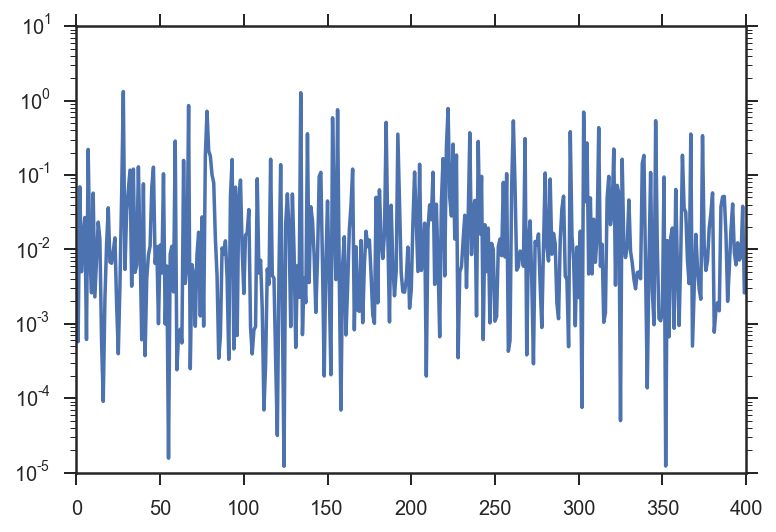

In [307]:
plot(samples['dndlnpdlnr'][::10,11,0])
yscale('log')
print mean(samples['dndlnpdlnr'][:,11,0])

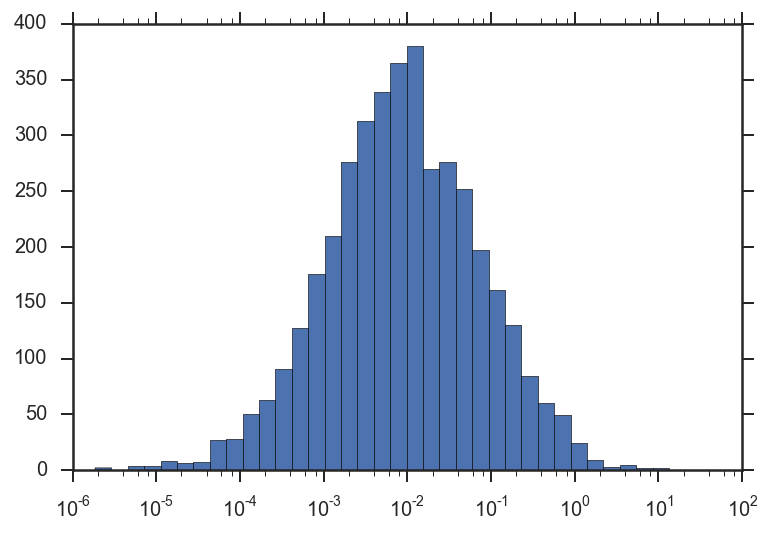

In [309]:
pu.plot_histogram_posterior(samples['dndlnpdlnr'][:,11,0], log=True)

In [301]:
(pbins[11], pbins[12]), (rbins[0], rbins[1])

((77.79463003658914, 128.26166128757163),
 (0.30326532985631671, 0.49999999999999994))

(0.31792887209941134,
 574.8288855359126,
 0.30326532985631671,
 27.299075016572118)

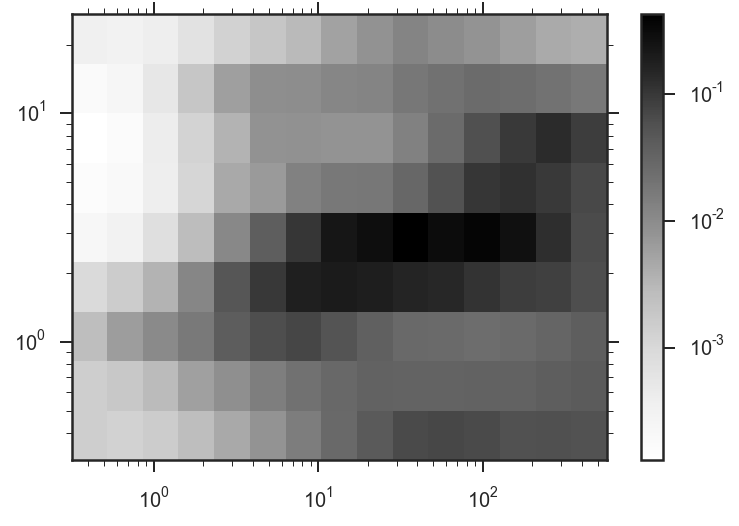

In [264]:
PS, RS = meshgrid(pbins, rbins, indexing='ij')
pcolormesh(PS, RS, mean(samples['dndlnpdlnr'][2000:,...], axis=0), norm=LogNorm())
colorbar()
xscale('log')
yscale('log')
axis(xmin=np.min(pbins), xmax=np.max(pbins), ymin=np.min(rbins), ymax=np.max(rbins))

In [265]:
mean(samples['metric'], axis=0)

array([[ 0.3739297 ,  0.01699073],
       [ 0.01699073,  2.51380894]])